# **Factorization Machine**



---
## Outline:

1. Background
2. Simplified Workflows.
3. Importing Data
4. Data Preparations
5. Data Preprocessing
6. Modeling
7. Hyperparameter Tuning
8. Evaluation
9. Decision Process (Recommendation Process)

# **Background**
---

## Problem Description
---

- A Travel Company **Trip Advisor** are having a problem with its user retention.
- In 3 months, the user retention rate dropped almost 20% which really affects **Trip Advisor** revenues.
- After doing an urgent user research, **Trip Advisor** team found that user spend time less in their platform because not knowing what to do in the platform ,

## Business Objective
---

- Our business objective would be **increasing user retention** to **20%** (assumed ofcourse) in 3 months.

## Solution
---


- We can create a **travel recommendation** to help **users browse** the hotel / venue for their vacation

The goal, of our recommendation is to recommend movies hotel / venue they might like, however its quite abstract. We may have to create **proxy label** to approach that problem

To approach those, some appropriate proxy labels are :    
- Scale of rating (star) user  given to a hotel / venue
- User click the movie
- etc

We have data of user rating towards item , in this case hotel / venue, beside we also have **contextual data**.

We can move further into machine learning task.

**Our task** is to predict number of stars given from user to a movie.

With  stars itself is in continous value, hence we can conclude it as **regression task**.

We now have a clearer picture what we should do, However we need more precise solution in recommender system context.

Approach in Personalized Recommender System can be divided based on the presence of interaction data (explicit / implicit) data:     

1. When the interaction data is not exists, the solution that can be implemented is using content feature, **Content Based** Filtering

2. When the interaction data is exists, we can use **Collaborative** Filtering

We can use **Context Aware Recommender System** to utilize context data in our recommender system.

## Model Metrics
---
We have already established some points :
- Our task is to predict stars that will be given by users to certain movies
- We will use Collaborative Filtering approach

Regarding those, we need to measure the success of our model ( metrics), based on the points mentioned, our goal is to predict as close as possible the predicted rating to user true rating,



We want to minimize $(\text{True Rating - Predicted Rating})$, some choices of appropriate metrics are :     
- Mean Absolute Error
- Mean Square Error
- Root Mean Squared Error

Due to its `differentiable` property , we will choose **MSE/RMSE** as our model metrics

## Data Description
---

- The data is obtained from [Trip Advisor dataset](https://grouplens.org/datasets/movielens/).


Only one file we use

**rating data** : `tripadvisor_travel.csv`

<center>

|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`user_id`|The user ID|`object`|
|`item_id`|The item / hotel ID|`int`|
|`rating`|Rating given from user to item. Ranging from `1` to `5`|`float`|
|`trip`|Trip Type (Context Data) : `['SOLO', 'FAMILY', 'COUPLES', 'BUSINESS', 'FRIENDS']`|`object`|


# **Recommender System Workflow** (Simplified)
---

## <font color='cyan'>1. Importing Data</font>

```
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.
```

## <font color='cyan'>2.Modelling : Factorization Machine</font>

```
1. Creating Utility Matrix
2. Training + Model Selection  :     
    - Baseline (Dummy Classifier)
    - Factorization Machines

4. Evaluating Model
  - Rating Prediction Task

```


## <font color='cyan'>3. Generating Recommendation / Predictions</font>

```
1. Predict recommendation of user-i to unrated item-j with context
2. Predict recommendation of user-i to all their unrated items with context
```

# **1. Importing Data**
---

What do we do?
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

In [1]:
# Load this library
import numpy as np
import pandas as pd

In [2]:
# Giving the path
trip_data_path = r"data\trip_advisor_travel.csv"

# Loading the data
data = pd.read_csv(trip_data_path,
                          delimiter = ',')

# Showing first 5 data
data.head()

,user_id,item_id,rating,trip
0,5C28F393B23BB894523AE7126A7AE445,219668,5,SOLO
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,5,SOLO
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,5,FAMILY
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,5,SOLO
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,5,COUPLES


In [3]:
# Check data shapes
data.shape

(14175, 4)

In [4]:
data.dtypes

user_id    object
item_id     int64
rating      int64
trip       object
dtype: object

- Features type: `user_id`, `item_id`, `rating`, and `trip`

In [5]:
# Check duplicate data
data.duplicated(subset=['user_id', 'item_id','trip']).sum()

326

In [6]:
clean_data = data.drop_duplicates(subset=['user_id', 'item_id','trip'])

In [7]:
# Check duplicate data
clean_data.duplicated(subset=['user_id', 'item_id','trip']).sum()

0

In [8]:
print('- Data Shape before dropping duplicate data', data.shape)
print('- Data Shape after dropping duplicate data', clean_data.shape)

- Data Shape before dropping duplicate data (14175, 4)
- Data Shape after dropping duplicate data (13849, 4)


In [9]:
# Creating loading fucntion
def load_trip_data(path):
    """
    Function to load data & remove from duplicates

    Parameters
    ----------
    path : str
        The path of trip data

    Returns
    -------
    trip_data : pandas DataFrame
        The sample of trip_data data
    """
    # Load data
    trip_data = pd.read_csv(path, delimiter=',')
    print('- Original data shape :', trip_data.shape)

    # drop duplicate data
    trip_data = trip_data.drop_duplicates(subset=['user_id', 'item_id','trip'])
    print('- After dropping duplicate data shape : ',trip_data.shape)

    return trip_data

In [10]:
# Loading rating data
trip_data = load_trip_data(path = trip_data_path)

- Original data shape : (14175, 4)
- After dropping duplicate data shape :  (13849, 4)


In [11]:
trip_data.head()

,user_id,item_id,rating,trip
0,5C28F393B23BB894523AE7126A7AE445,219668,5,SOLO
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,5,SOLO
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,5,FAMILY
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,5,SOLO
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,5,COUPLES


# **2. Modelling**: Context Aware Collaborative Filtering
---

## Background
---

Previously, we createdrecommender system by Matrix Factorization / Latent Factor Model Approach. However, in our matrix factorization approach we have not addressed how to add contextual features, such as : time, place, etc.

We might think that now, our utility matrix is not only involved user factor or item factor, but also add **context** factor.

We learnt that, there are 3 solutions to add context into our modelling :      
1. Contextual PreFiltering

<img src="https://www.researchgate.net/publication/258920113/figure/fig2/AS:297180343619593@1447864723798/Flow-model-of-contextual-pre-filtering-6.png" img>

<a href="https://www.researchgate.net/publication/258920113/figure/fig2/AS:297180343619593@1447864723798/Flow-model-of-contextual-pre-filtering-6.png">Source </a>

2. Contextual PostFiltering


<img src="https://www.researchgate.net/publication/304781330/figure/fig1/AS:381298381213699@1467920026542/Contextual-post-filtering.png" img>

<a href="https://www.researchgate.net/publication/304781330/figure/fig1/AS:381298381213699@1467920026542/Contextual-post-filtering.png">Source </a>


3.Contextual Modelling

In this approach we do'not filter context, instead we use it as "feature" in our modelling phase

Some approach :    
1. Latent Factor Approach

  example : Tensor Factorization, Matrix Factorization with Side Features

2. Factorization Machines

## Workflow
---

To create a personalized RecSys, we can follow these steps:

```
1. Data Preparation --> Create utility matrix & Split Train-Test
2. Train recommendation model --> Baseline, User to User CF (KNN) & Item to Item CF (KNN)
3. Choosing Best Model
5. Evaluate Final Model
```

## Implementing Model From Scratch
---

### Factorization Machine from Scratch : Regression Task
---

**Task : Rating Prediction**

Factorization Machine is basically the same as our `familiar` Linear Regression model basic form, which is :

$$
f(x) = mx + c
$$

When we have lot of feature it will become :
$$
f(x) = m_1.x_1 + ... m_n.x_n + c 
$$

and to summarize :
$$
f(x) = \sum_i^nm_i.x_i + c 
$$

where $m$ is weight or coefficient.

Where in Recommender System context we hypothesize that our features such as :    
1. User
2. Item
3. Contextual data

has relation to each other.

We can add interaction factor to each feature as follow :

$$
f(x) = \sum_i^nm_i.x_i + c + \sum_{i=1} \sum_{j=1+1} w_{i,j} x_i.x_j 
$$

instead of using weight to each interaction, we can create interaction term for each feature and represented it as latent factor with below equation :

$$
f(x) = \sum_i^nm_i.x_i + c + \sum_{i=1} \sum_{j=1+1} <v_i.v_j> x_i.x_j
$$

Hereby we represent our feature as latent factor, hence we can choose number of number latent factor to represent each feature, let say if we choose 3 latent factor.

$$
f(x) = \sum_i^nm_i.x_i + c + \sum_{f=1}^{k=3} \sum_{i=1} \sum_{j=1+1} v_{i,f}.v_{i,f} x_i.x_j
$$

Or in general we depend on number of latent factor `k`

$$
f(x) = \sum_i^nm_i.x_i + c + \sum_{f=1}^{k} \sum_{i=1} \sum_{j=1+1} v_{i,f}.v_{i,f} x_i.x_j
$$

#### Data Preparation

In this process we will prepare our data so that we can continue to training process, the expected output should be array with size `<n_records x features>` with

with features ordered :     
- feature 1 : `userId`
- feature 2 : `movieId`
- feature 3 : `rating`


<img src="https://drive.google.com/uc?export=view&id=1Qqp4HD9qVkiwKxn2clVtfdpujSd6kUea" width=600>


#### Mapping User and Item ID

To create mapping, we can simply create dictionary, which stores :    
- UserId to ordered id
```python
user_to_id = {userid : orderedid}
#example
user_to_id = {'ab' : 1}
```
- Ordered id to UserId
```python
user_to_id = {orderedid : userid }
#example
user_to_id = {1 : 'ab' }
```

In [12]:
# mapping user to ordered id
user_to_id = {user : idx for idx,user in enumerate(trip_data['user_id'].unique())}

id_to_user = {idx : user for idx,user in enumerate(trip_data['user_id'].unique())}

In [13]:
# mapping item to ordered id
item_to_id = {item : idx for idx,item in enumerate(trip_data['item_id'].unique())}

id_to_item = {idx : item for idx,item in enumerate(trip_data['item_id'].unique())}

In [14]:
mapped_data = trip_data.copy()
mapped_data['user_id'] = mapped_data['user_id'].map(user_to_id)
mapped_data['item_id'] = mapped_data['item_id'].map(item_to_id)

In [15]:
trip_data.head()

,user_id,item_id,rating,trip
0,5C28F393B23BB894523AE7126A7AE445,219668,5,SOLO
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,5,SOLO
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,5,FAMILY
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,5,SOLO
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,5,COUPLES


In [16]:
mapped_data.head()

,user_id,item_id,rating,trip
0,0,0,5,SOLO
1,1,1,5,SOLO
2,2,2,5,FAMILY
3,1,3,5,SOLO
4,3,4,5,COUPLES


#### One Hot Encoding

Remember that, now beside our utility matrix we have `context` data , in our case, `trip` type

Into : 
     
<img src="https://drive.google.com/uc?export=view&id=1pAkYN3kJ-O7-p5BLEwucRhjKEr7wxToO" width=600>


Converting data into categorical type, so that we could create One Hot Encoding based on available data

In [17]:
mapped_data['user_id'] = mapped_data['user_id'].astype('category')
mapped_data['item_id'] = mapped_data['item_id'].astype('category')
encoded_data = pd.get_dummies(mapped_data[['user_id','item_id','trip']])

In [18]:
encoded_data.head()

,user_id_0,user_id_1,user_id_2,user_id_3,user_id_4,user_id_5,user_id_6,user_id_7,user_id_8,user_id_9,...,item_id_2264,item_id_2265,item_id_2266,item_id_2267,item_id_2268,trip_BUSINESS,trip_COUPLES,trip_FAMILY,trip_FRIENDS,trip_SOLO
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


Now, we have seen that we already prepare all the data, we may want to use the preprocessing step again, we better create the function

In [19]:
# Function to map data
def map_data(trip_data) :
    user_to_id = {user : idx for idx,user in enumerate(trip_data['user_id'].unique())}
    id_to_user = {idx : user for idx,user in enumerate(trip_data['user_id'].unique())}

    # mapping item to ordered id
    item_to_id = {item : idx for idx,item in enumerate(trip_data['item_id'].unique())}
    id_to_item = {idx : item for idx,item in enumerate(trip_data['item_id'].unique())}

    trip_data['user_id'] = trip_data['user_id'].map(user_to_id)
    trip_data['item_id'] = trip_data['item_id'].map(item_to_id)

    user_mapping = {
        'user_to_id' : user_to_id,
        'id_to_user' : id_to_user
    }

    item_mapping = {
        'item_to_id' : item_to_id,
        'id_to_item' : id_to_item
    }

    return trip_data,user_mapping,item_mapping

#### Data Preparation Function

In [20]:
def preprocess_data(trip_data) :
    """
    Function to preprocess data
    Parameters
    ----------
    trip_data : pandas.DataFrame
        contain the trip data

    Returns
    -------
    trip_data : pandas DataFrame
        The sample of trip_data data

    mapping_user : dict
        contain mappers :
        1. user to id
        2. id to user

    mapping_item : dict
        contain mappers :
        1. item to id
        2. id to item

    """
    # copy to avoid overwriting the original dataframe
    trip_data = trip_data.copy()

    trip_data, mapping_user, mapping_item = map_data(trip_data= trip_data)

    # change data type from user and item id to category
    trip_data['user_id'] = trip_data['user_id'].astype('category')
    trip_data['item_id'] = trip_data['item_id'].astype('category')

    # create one hot encoding
    encoded_data = pd.get_dummies(trip_data[['user_id','item_id','trip']], dtype=int)

    # combine again with the target variable
    all_data = pd.concat([encoded_data,trip_data[['rating']]],axis=1)


    feature_names = encoded_data.columns.tolist()
    return all_data, mapping_user, mapping_item,feature_names

In [21]:
processed_data,mapping_user,mapping_item,feature_names = preprocess_data(trip_data=trip_data)

In [22]:
processed_data.head()

,user_id_0,user_id_1,user_id_2,user_id_3,user_id_4,user_id_5,user_id_6,user_id_7,user_id_8,user_id_9,...,item_id_2265,item_id_2266,item_id_2267,item_id_2268,trip_BUSINESS,trip_COUPLES,trip_FAMILY,trip_FRIENDS,trip_SOLO,rating
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5


Now, we already satistified with `Factorization Machines` requirement, however we see that we have `4646` features with mostly zero values. It will be quite inefficient to store if we store it as dataframe , hence we will convert it to sparse matrix. 

#### **Converting DataFrame to sparse matrix**

##### Data Splitting

We are going to split our data into training and test data, we are not splitting like before, because our utility matrix + context now become general machine learning algorithm training samples `<X,Y>`

In [23]:
X = processed_data.drop('rating',axis=1)
y = processed_data['rating']

from sklearn.model_selection import train_test_split

# split the data
X_train,X_test,y_train,y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size= 0.2)

In [24]:
print('Shape of X_train',X_train.shape)
print('Shape of X_train',X_test.shape)
print('Shape of y_train',y_train.shape)
print('Shape of y_test',y_test.shape)

Shape of X_train (11079, 4645)
Shape of X_train (2770, 4645)
Shape of y_train (11079,)
Shape of y_test (2770,)


##### All about Sparse Matrix


We previously has formed , `Sparse Data`, mostly with 0 values, however it will deal with serious problem, if we do that in just pure numpy array. We need to utilize what called as **sparse matrix**. 

There are lot of variety sparse matrix, but most common is `Compressed Sparse Row/Column`

<img src="https://matteding.github.io/images/csr.gif" >
<center> <a href="https://matteding.github.io/images/csr.gif">Source</center>

CSR matrix consist of several elements :      
1. Indices

   Could be column or row location which contain data,
   if we use compressed sparse row --> our indices is the column

2. Indices Pointer

   This is the opposite of our indices, if our indices is in column , then the pointer is in row,
   

3. Data

   Non Missing Data

- Let's say we have a sparse matrix as below :

In [25]:
sparse_matrix = np.array(
        [[8, 0, 2, 0, 0],
        [0, 0, 5, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 7, 1, 2],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 9, 0]])

sparse_matrix

array([[8, 0, 2, 0, 0],
       [0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 7, 1, 2],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 9, 0]])

And we could built the sparse matrix version of it as below :

In [26]:
# import scipy
import scipy.sparse as sp

# convert to csr_matrix
s_matrix_csr = sp.csr_matrix(sparse_matrix)
s_matrix_csr

<7x5 sparse matrix of type '<class 'numpy.intc'>'
	with 7 stored elements in Compressed Sparse Row format>

- Numpy Version of Sparse matrix

In [27]:
# loop all over row
  # loop all over col
for row_idx in range(sparse_matrix.shape[0]) :
    for col_idx in range(sparse_matrix.shape[1]) :
        print(f'Row : {row_idx} Col : {col_idx} Value : ',sparse_matrix[row_idx,col_idx])

Row : 0 Col : 0 Value :  8
Row : 0 Col : 1 Value :  0
Row : 0 Col : 2 Value :  2
Row : 0 Col : 3 Value :  0
Row : 0 Col : 4 Value :  0
Row : 1 Col : 0 Value :  0
Row : 1 Col : 1 Value :  0
Row : 1 Col : 2 Value :  5
Row : 1 Col : 3 Value :  0
Row : 1 Col : 4 Value :  0
Row : 2 Col : 0 Value :  0
Row : 2 Col : 1 Value :  0
Row : 2 Col : 2 Value :  0
Row : 2 Col : 3 Value :  0
Row : 2 Col : 4 Value :  0
Row : 3 Col : 0 Value :  0
Row : 3 Col : 1 Value :  0
Row : 3 Col : 2 Value :  0
Row : 3 Col : 3 Value :  0
Row : 3 Col : 4 Value :  0
Row : 4 Col : 0 Value :  0
Row : 4 Col : 1 Value :  0
Row : 4 Col : 2 Value :  7
Row : 4 Col : 3 Value :  1
Row : 4 Col : 4 Value :  2
Row : 5 Col : 0 Value :  0
Row : 5 Col : 1 Value :  0
Row : 5 Col : 2 Value :  0
Row : 5 Col : 3 Value :  0
Row : 5 Col : 4 Value :  0
Row : 6 Col : 0 Value :  0
Row : 6 Col : 1 Value :  0
Row : 6 Col : 2 Value :  0
Row : 6 Col : 3 Value :  9
Row : 6 Col : 4 Value :  0


**Compressed Sparse Row** version

in this version of sparse matrix we can only access **Non Zero Values** data

In [28]:
s_matrix_csr.indptr

array([0, 2, 3, 3, 3, 6, 6, 7])

In [29]:
s_matrix_csr.indices

array([0, 2, 2, 2, 3, 4, 3])

In [30]:
# we can loop all over indices pointer
row_length = sparse_matrix.shape[0]
for i in range(row_length)  :
    # access indices pointer, we should add +1
    for index in range(s_matrix_csr.indptr[i],s_matrix_csr.indptr[i+1]) :
      # print('index',index)
      print('data',s_matrix_csr.data[index])



data 8
data 2
data 5
data 7
data 1
data 2
data 9


In [31]:
# convert to scipy.csr matrix
X_train_sparse = sp.csr_matrix(X_train)
X_test_sparse  = sp.csr_matrix(X_test)

#### Objective

$$
\text{Objective}= \underset{}{\min}
\left [
 \sum_{n \in D} (y^{(n)}-\hat{y}^{(n)})^2
\right ]
$$

with
$$
\begin{align*}
\hat{y}^{(n)}
&= w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i}^{(n)} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 {x_{i}^{(n)}}^2 \right)
\end{align*}
$$


Our main goal is to minimize prediction error, between true rating and predicted rating


Add term $\cfrac{1}{2}$ (optional), the purpose is to make the derivative more simple

$$\text{Objective}= \underset{}{\min}
\left [
\cfrac{1}{2} \sum_{n \in D} (y^{(n)}-\hat{y}^{(n)})^2
\right ]
$$


$$
\begin{align*}
\text{Objective}
&= \underset{w_0,w^*,v*}{min} \left [\cfrac{1}{2}\sum_{n \in D} \left ( y^{n}- ( w_0 + \sum_{i=1} w_i.x_i^{(n)} +  \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_i^{(n)} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 {x_i^{(n)}}^2 \right) \right )^2 \right ]
\end{align*}
$$


Adding Regularization

the purpose of adding regularization is to make our model can avoid overfitting, we can add Ridge Regularization

**Final Objective Function**

$$
\begin{align*}
\text{Objective}
&= \underset{w_0,w^*,v*}{min} \left [\cfrac{1}{2}\sum_{n \in D} \left ( y^{n}- ( w_0 + \sum_{i=1} w_i.x_i^{(n)} +  \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_i^{(n)} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 {x_i^{(n)}}^2 \right) \right )^2 \right ] + \cfrac{\lambda}{2} \left [\sum_{i}(w_i^2 +||v_i||^2 ) \right ]
\end{align*}
$$



#### Initialization

There are three parameters of Factorization Machines :   
- $w_0$ : intercept a scalar value
- $w_i$ : feature weight , vector with size of `<n_features x 1>`
- $v_i$ : feature interaction latent factor, matrix with size of `<n_features x n_factor>`

In [32]:
n_sample,n_features = X_train.shape

In [33]:
# set number of latent factor
n_factor = 50

In [34]:
# set seed
np.random.seed(49)

# initialize parameter
# intercept
intercept = 0

# feature weight
w = np.random.normal(size=(n_features,1))

# feature interaction weight
v = np.random.normal(size=(n_factor,n_features))

In [35]:
# print shape
print('Shape of feature weight',w.shape)
print('Shape of feature interaction weight',v.shape)

Shape of feature weight (4645, 1)
Shape of feature interaction weight (50, 4645)


In [36]:
# loss function
def mse_loss(y_true, y_pred,lambda_coef,lambda_factor,w,v):
    """
    MSE Loss plus regularization term
    """
    loss = ((y_true - y_pred)**2) / 2
    regularization_loss = (lambda_coef*(norm(w)**2)) + lambda_factor*(norm(v)**2) / 2
    total_loss = loss + regularization_loss
    return total_loss

#### Prediction Function
$$
\begin{align*}
\hat{y}(\textbf{x})
&= w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align*}
$$


Previously we have prediction function
$$
\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} +  \sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}
$$


however we see that in
$$
\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}
$$

we have quite expensive computation
```{python}
# loop 1
for i in blabla :
  for j in i ..
    do something
```

Could we afford using only one loop instead of looping twice?
Yes, we could.. however we should modify it.
We could see that index  $j= i+1$, we could remove the term i by substracting them.

$$
\begin{align*}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j} - \frac{1}{2} \sum_{i=1}^n \langle \textbf{v}_i , \textbf{v}_{i} \rangle x_{i} x_{i}
\end{align*}
$$

As of now, we could recall that in our interaction feature represented by some n-length latent factor

$$
\begin{align*}
\langle \textbf{v}_i, \textbf{v}_{j} \rangle = \sum_{f=1}^k v_{i,f} v_{j,f}
\end{align*}
$$

plug back to our function :

$
\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j} \right) - \frac{1}{2}\left( \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j}  -  \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left(\sum_{i=1}^n v_{i,f}x_{i} \right) \left( \sum_{j=1}^n v_{j,f}x_{j} \right) - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}
$

Wee see that our index $j=i=1$, hence we can replace the j index with i

$
\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left(\sum_{i=1}^n v_{i,f}x_{i} \right) \left( \sum_{i=1}^n v_{i,f}x_{j} \right) - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}
$

Final Form : of Our Prediction Function

$
\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}
$

In [37]:
def predict(data,indptr, indices,w_0, w, v, n_factors,n_features,i):
    """" Predicting data on single training samples, from sparse matrices """

    # use this for updating parameter
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    y_pred = w_0

    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        y_pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        y_pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])


    return y_pred, summed

In [38]:
# predict on training samples 1
pred,summed = predict(data= X_train_sparse.data,
                      indptr = X_train_sparse.indptr,
                      indices = X_train_sparse.indices,
                      w_0 = intercept, w = w, v = v , n_factors = n_factor,
                      n_features = X_train.shape[1],
                      i = 1
                      )
print('Prediction on sample 1 : ', pred)

Prediction on sample 1 :  [-13.42671964]


#### Optimization

To find optimal parameter above we will find using one of the famous optimization algorithm, **Gradient Descent**, and to perform Gradient Descent we have to find optimal parameter when derivative of cost function with respect to each parameter is 0.

Since our objective is in composite function, $h(x) = f(g(x))$, to find the partial derivative with respect to each parameter we can use **chain rule**; $h'(x) = f'(g(x)).g'(x)$

##### 1. **$w_0$**






###### Derivation Detail of $w_0$

$$
\begin{align*}
\text{Objective}
&= \underset{w_0,w^*,v*}{min} \left [\cfrac{1}{2}\sum_{n \in D} \left( y^{n}- \left (w_0 + \sum_{i=1} w_i.x_i^n +  \frac{1}{2} \sum_{f=1}^{k} ( \left( \sum_{i}^{n} v_{i,f}x_i^n \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 {x_i^n}^2 \right)  \right )^2 \right ] + \cfrac{\lambda}{2} \left [\sum_{i}(w_i^2 +||v_i||^2 ) \right ]
\end{align*}
$$

**1st Block**

Now we take care of each derivative $\left [ \text{some function} \right ]$ block

$$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{n \in D}  (y^{(n)}- \hat{y}^{(n)} )^2)}{\partial{w_0}}
\end{align*}
$$

Where we could identify :     
- $\hat{y}^{(n)}$ is our prediction function , we could call it as `g(x)`
- $\left [
(\cfrac{1}{2}\sum_{n \in D}  (y^{(n)}- \hat{y}^{(n)} )^2)\right ]$ is our `f(g(x))`


Hence, our derivation become

$$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{n \in D}  (y^{(n)}- \hat{y}^{(n)} )^2)}{\partial{w_0}}
&=
\cfrac{1}{2} \frac{\partial{f(g(x))}}{\partial{g(x)}}. \frac{\partial{g(x)}}{\partial{w_0}}
\end{align*}
$$

Remember derivative concept, if we have $f(x) = ax^n$, the derivative or $f'(x) = n(ax^{n-1})$

$$
 \begin{align*}
\frac{\partial{f(g(x))}}{\partial{g(x)}}
&= 2 \sum_{n \in D} (y^{(n)}- \hat{y}^{(n)} )
\end{align*}
$$

and

$$
\begin{align*}
-\frac{\partial{g(x)}}{\partial{w_0}}
&= \frac{\partial{\left (w_0 + \sum_{i=1} w_i.x_i^n +  \frac{1}{2} \sum_{f=1}^{k} ( \left( \sum_{i}^{n} v_{i,f}x_i^n \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 {x_i^n}^2 \right)}}{\partial{w_0}} \\
&= -1
\end{align*}
$$

Plug back each component

$$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{n \in D}  (y^{(n)}- \hat{y}^{(n)} )^2)}{\partial{w_0}}
&=
\cfrac{1}{2} \frac{\partial{f(g(x))}}{\partial{g(x)}}. \frac{\partial{g(x)}}{\partial{w_0}} \\
&= \cfrac{1}{2} 2 \sum_{n \in D} (y^{(n)}- \hat{y}^{(n)} ) . -1 \\
&= -\sum_{n \in D} (y^{(n)}- \hat{y}^{(n)} )
\end{align*}
$$

**2nd Block**

$$
\begin{align*}
\frac{1}{2}\frac{\partial{\cfrac{\lambda}{2} \left [\sum_{i}(w_i^2 +||v_i||^2 ) \right ]} }{\partial{w_0}}
\end{align*}
$$

Since we don't have $w_0$ term in our regularization, our derivation should be $0$.




**Arrange All Component**

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{w_0}}
&=
\frac{\partial}{\partial{w_0}}
\underset{}{}
\left [
(\cfrac{1}{2}\sum_{n \in D}  (y^{(n)}- \hat{y}^{(n)})^2)\right ] + \frac{\partial}{\partial{w_0}} \left [ \cfrac{\lambda}{2} \sum_{i} (w_i^2 +||v_i||^2 ) \right ] \\
&= \left [(2.\cfrac{1}{2}\sum_{n \in D} (y^{(n)}- \hat{y}^{(n)}).-1 \right ] + 0 \\
&= -\sum_{n \in D} (y^{(n)}- \hat{y}^{(n)})  \\
\text{Multiply with -1} \\
\cfrac{\partial \text{Objective}}{\partial{w_0}}
&= \sum_{n \in D} (y^{(n)}- \hat{y}^{(n)})
\end{align*}
$$

$$
\sum_{n \in D}(y^{(n)} - \hat{y}^{(n)})
$$

##### 2. **$w_i$**


Using the same procedure as above

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{w_i}}
&= \sum_{n \in D}(y^{(n)} - \hat{y}^{(n)}).\sum_i x_i^{(n)} +   (\lambda \sum_i w_i))
\end{align*}
$$

Remember :      
- $ \sum_i x_i^{(n)} = X^{n} $

##### 4. **$v_{i,f}$**
Suppose we use the same technique, we will endup with


$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{w_{i,f}}}
&= \sum_{n \in D}(y^{(n)} - \hat{y}^{(n)}). x_i \sum_{f=1}^k \sum_{j=1}^n v_{j,f}.x_j - v_{i,f}x_i^2 + \lambda\sum_i \sum_f^k v_{i,f}
\end{align*}
$$


##### Optimization Detail

To update the parameter to optimal we need other components :     

- $\gamma$ : Learning rate
- n_epochs : number of iteration to update the parameter

How gradient descent work to update parameter :    
For n_iterations do :    
Loop all over training samples :     
1. Find  partial derivative /gradient of objective function with respect to parameter we want to optimize ( in this case $b_u,b_i,p_u,q_i$)

2. Update parameter with those gradient :     

  $\text{parameter}_{\text{new}} = \text{parameter}_{\text{old}} -\gamma.(\text{gradient})$


There are lot of alternatives to original **Gradient Descent**, such as :     
1. Mini batch Gradient Descent
2. Stochastic Gradient Descent

In [40]:
from tqdm import tqdm
from numpy.linalg import norm

In [39]:
# hyperparameter
# regularization of coefficient
lambda_coef = 0.002
# regularization of interaction term
lambda_factor = 0.002
# learning rate
learning_rate = 0.001
# n_epoch
n_epoch = 100

In [41]:
# implement stochastic gradient descent
history_loss = []
for epoch in tqdm(range(n_epoch)) :
  # pick random sample (stochastic)
  idx = np.arange(X_train.shape[0])
  i = np.random.choice(idx)

  # set loss for each epocj
  loss = 0.0
  # run prediction
  y_pred, summed = predict(data= X_train_sparse.data, indptr= X_train_sparse.indptr,
                                      indices= X_train_sparse.indices, w_0 = intercept, w= w,
                                      v= v , n_factors = n_factor,
                                      n_features = n_features,i=i)

  # calculate loss and its gradient
  loss += mse_loss (y_true= y_train[i], y_pred= y_pred, lambda_coef =lambda_coef,
                    lambda_factor=lambda_factor,w=w, v= v)
  # add loss
  history_loss.append(loss)

  # error gradient 1/2 * dy/dx (MSE)
  error_gradient = (y_train[i] - y_pred)

  # update_intercept
  intercept += (learning_rate * error_gradient)

  # update weight
  # iterate through all pointer (row)
  for index in range(X_train_sparse.indptr[i], X_train_sparse.indptr[i + 1]):
      # slice indices (row) based on
      feature = X_train_sparse.indices[index]
      w[feature] += learning_rate * (error_gradient * X_train_sparse.data[index] + lambda_coef * w[feature])


  # update each interaction factor
  for factor in range(n_factor):
      for index in range(X_train_sparse.indptr[i], X_train_sparse.indptr[i + 1]):
          feature = X_train_sparse.indices[index]
          term = summed[factor] - v[factor, feature] * X_train_sparse.data[index]
          v_gradient = error_gradient * X_train_sparse.data[index] * term
          v[factor, feature] += learning_rate * (v_gradient +  lambda_factor * v[factor, feature])


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\daniel.satria\AppData\Local\Temp\ipykernel_2716\894921705.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[factor, feature] += learning_rate * (v_gradient +  lambda_factor * v[factor, feature])
100%|██████████| 100/100 [00:00<00:00, 238.09it/s]


In [43]:
#### Object Oriented Code

In [42]:
from sklearn.base import BaseEstimator, RegressorMixin


class FMRegressor(BaseEstimator, RegressorMixin):
    """
    Factorizaton Machines for Regression Task

    Parameters
    ----------
    n_epoch : int, default 100
        Number of iterations

    n_factors : int, default 20
        Number of latent factor for feature interaction

    lr : float, default 0.001
        Learning rate for the Stochastic Gradient Descent

    lambda_coef : float, default 0.1
        Regularization strength for weights.

    lambda_factor : float, default 0.1
        Regularization strength for interaction latent factors.

    random_state : int, default 49
        Seed for reproducibility

    """

    def __init__(self, n_epoch = 10, n_factors = 20,
                 lr = 0.01, lambda_coef = 0.1,lambda_factor = 0.1,
                 random_state = 49):
        self.n_epoch = n_epoch
        self.lambda_coef = lambda_coef
        self.lambda_factor = lambda_factor
        self.n_factors = n_factors
        self.random_state = random_state
        self.lr = lr

    def initialize_parameters(self,n_features) :
        """Function to initialize parameters"""

        # intercept --> w_0
        self.intercept_ = 0.0

        # weight --> w_i
        self.coef_ = np.zeros(n_features)

        # initialized interaction factor for each features (users,item,other features)
        self.feature_factors_ = np.random.normal(0.,1.,size = (self.n_factors, n_features))


    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape <n_samples, n_features>
            Data in sparse matrix format.

        y : 1d ndarray, shape <n_samples,>
            Training data's corresponding target (rating).

        Returns
        -------

        """

        self.n_samples, self.n_features = X.shape

        # setting seed
        np.random.seed(self.random_state)

        self.initialize_parameters(n_features= self.n_features)


        self.history_ = []
        for epoch in tqdm(range(n_epoch)) :
            loss = update_parameter(data = X.data,indptr= X.indptr, indices = X.indices, y = y ,
                              n_samples=self.n_samples,
                              n_features = self.n_features, w_0 = self.intercept_,
                              w = self.coef_, v= self.feature_factors_,
                              n_factors = self.n_factors, learning_rate = self.lr,
                              lambda_coef= self.lambda_coef,lambda_factor = self.lambda_factor)
            self.history_.append(loss)


    def predict(self, X):
        """Prediction function for inference (after training)"""

        # check instance
        if isinstance(X,sp._csr.csr_matrix) :
            # convert if X is sparse matrix to numpy matrix
            X = X.toarray()

        # W_i.x_i
        linear_output = X.dot(self.coef_).reshape(1,-1)[0]

        # feature interaction
        v = self.feature_factors_.T
        term = (X.dot(v)) ** 2 - ((X**2).dot(v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)

        # sum all prediction
        y_pred = self.intercept_ + linear_output + factor_output

        # implement clipping
        for i in range(len(y_pred)) :
          if y_pred[i] > 5 :
            y_pred[i] = 5
          elif y_pred[i]  < 1 :
            y_pred[i]  = 1

        return y_pred



def update_parameter(data,indptr,indices,y,n_samples, n_features,
                w_0, w, v, n_factors, learning_rate, lambda_coef ,lambda_factor):
    """
    Update parameter
    """
    # set loss
    loss = 0.0

    # pick random sample to update
    idx = np.arange(n_samples)
    i = np.random.choice(idx)

    # generate prediction
    y_pred, summed = _predict_instance(data= data, indptr= indptr,
                                        indices= indices, w_0 = w_0, w= w,
                                        v= v , n_factors = n_factors,
                                        n_features = n_features,i=i)

    # calculate loss and its gradient
    loss += mse_loss (y_true= y[i], y_pred= y_pred, lambda_coef =lambda_coef,
                      lambda_factor=lambda_factor,w=w, v= v)

    # error gradient 1/2 * dy/dx (MSE)
    error_gradient = (y[i] - y_pred)

    # update_intercept
    w_0 += (learning_rate * error_gradient)

    # update weight
    # iterate through all pointer (row)
    for index in range(indptr[i], indptr[i + 1]):
        # find feature that are not have zeros value (sparse)
        feature = indices[index]
        # update w
        w[feature] += learning_rate * (error_gradient * data[index] + lambda_coef * w[feature])


    # update each interaction factor
    for factor in range(n_factors):
        # iterate through all pointer (row)
        for index in range(indptr[i], indptr[i + 1]):
            # find feature that are not have zeros value (sparse)
            feature = indices[index]
            # calculate term
            term = summed[factor] - v[factor, feature] * (data[index]**2)

            # dy / dx
            v_gradient = error_gradient * data[index] * term

            v[factor, feature] += learning_rate * (v_gradient +  lambda_factor * v[factor, feature])

    loss /= n_samples
    return loss


def _predict_instance(data,indptr, indices,w_0, w, v, n_factors,n_features,i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    y_pred = w_0

    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        y_pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        y_pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])


    return y_pred, summed

In [44]:
model = FMRegressor(n_epoch=1000,lambda_coef=0.01,lr=0.01,n_factors=100)

In [45]:
%timeit
model.fit(X_train_sparse,y_train)

100%|██████████| 100/100 [00:00<00:00, 479.19it/s]


In [46]:
model.intercept_

0.0

In [47]:
model.history_

[2.103573903355957,
 2.136507927599461,
 2.103049059879899,
 2.1193881797312457,
 2.1083262422989826,
 2.1204941301550786,
 2.105060869124429,
 2.1030408805127476,
 2.1067035819871007,
 2.106168640353143,
 2.134485999350442,
 2.1450680132893494,
 2.1047231656318246,
 2.119392957670942,
 2.161217107732948,
 2.1038682542460565,
 2.125228268678829,
 2.1093575433773943,
 2.138174494062725,
 2.105489081134886,
 2.107482642871969,
 2.115176043509399,
 2.1049654409038743,
 2.1076751768648765,
 2.104143050039917,
 2.1060875857068018,
 2.1036943630232843,
 2.104299353428089,
 2.1289877950385474,
 2.106379419924681,
 2.1230874134293334,
 2.109664787352479,
 2.1094709352695316,
 2.1044701255657094,
 2.1438244960722788,
 2.1040429636979003,
 2.1140084603116436,
 2.11597913076335,
 2.1570428692230843,
 2.116903652848005,
 2.1131704078581697,
 2.1187938036781553,
 2.1044833287078437,
 2.1123018015345827,
 2.10718618232965,
 2.135716987082862,
 2.1068041629820597,
 2.177812545572116,
 2.1091789793669

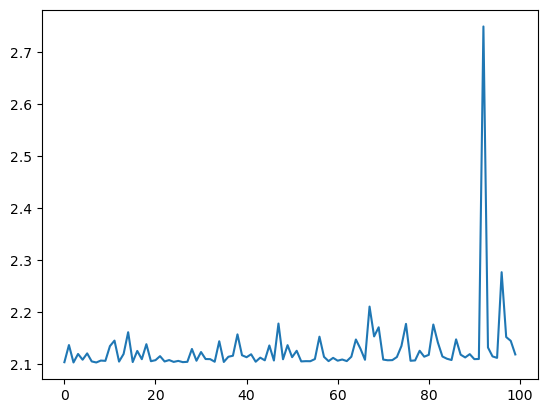

In [48]:
import matplotlib.pyplot as plt

plt.plot([x for x in range(len(model.history_))],model.history_,)

In [49]:
y_pred = model.predict(X_train_sparse)
y_pred

array([5., 1., 1., ..., 5., 5., 1.])

In [50]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_train,y_pred))

2.5017739556046976

#### Generating Prediction

We already train our `Factorization Machine Models`, now we want to generate prediction on  one of our user. We want to predict the rating that will be given by user `5C28F393B23BB894523AE7126A7AE445` on item `219668`, on context `SOLO` trip.
Previously, we map the the user and item id, so we retrieve it first

In [62]:
target_userid = 'CAFAF8275C721F57AB58686ECC5AEC41'
target_itemid = 1149361
target_context = 'SOLO'

In [63]:
# retrieve mapping
user_id = user_to_id[target_userid]
item_id = item_to_id[target_itemid]

print(f'Mapped User id : {user_id}, Item id : {item_id}')

Mapped User id : 16, Item id : 10


We, see that our input for each training data consist of `<4645>` features, we need to process to create format data for inference / prediction.

We could use the same format as our `processed_data`, and assign values.

In [64]:
data_prediction_format = X.iloc[[1]]
data_prediction_format

,user_id_0,user_id_1,user_id_2,user_id_3,user_id_4,user_id_5,user_id_6,user_id_7,user_id_8,user_id_9,...,item_id_2264,item_id_2265,item_id_2266,item_id_2267,item_id_2268,trip_BUSINESS,trip_COUPLES,trip_FAMILY,trip_FRIENDS,trip_SOLO
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [81]:
# replace all data with 0
data_prediction_format.loc[:] = 0
data_prediction_format

,user_id_0,user_id_1,user_id_2,user_id_3,user_id_4,user_id_5,user_id_6,user_id_7,user_id_8,user_id_9,...,item_id_2264,item_id_2265,item_id_2266,item_id_2267,item_id_2268,trip_BUSINESS,trip_COUPLES,trip_FAMILY,trip_FRIENDS,trip_SOLO
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# now will fill the user_id from our target with 1
data_prediction_format.loc[:,f'user_id_{user_id}'] = 1

In [83]:
# now will fill the item_id from our target with 1
data_prediction_format.loc[:,f'item_id_{item_id}'] = 1

In [84]:
# now will fill the trip_context from our target with 1
data_prediction_format.loc[:,f'trip_{target_context}'] = 1

Now, we will convert into numpy array

In [85]:
X_samples = data_prediction_format.to_numpy()

In [86]:
# run prediction
model.predict(X_samples)

array([1.])

Since, later we want to generate prediction, we will create function to prepare inference / prediction data

In [87]:
def prepare_prediction_input(user_id, item_id, context,
                             data_prediction_format = data_prediction_format) :
    """Function to prepare prediction / inference data"""
    # copy
    data_prediction_format = data_prediction_format.copy()

    # assign all values from each column to zero
    data_prediction_format.loc[:,] = 0

    # now will fill the user_id
    data_prediction_format.loc[:,f'user_id_{user_id}'] = 1

    # now will fill the item_id
    data_prediction_format.loc[:,f'item_id_{item_id}'] = 1

    # now will fill the trip_context
    data_prediction_format.loc[:,f'trip_{target_context}'] = 1

    # return numpy data
    return data_prediction_format.to_numpy()

In [88]:
y_pred = model.predict(X_test_sparse)

In [89]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test,y_pred))

2.576658922044949

## Train Recommender System Models
---

To Model on Factorization Machine we are going to use polylearn package, which is under sklearn package

### Load the Data
---

Now, we already satistified with `Factorization Machines` requirement

### Experiment
---

We want to train all model candidate with its hyperparameter so that we can compare which model + settings yield good result


<img src="https://drive.google.com/uc?id=1UzWBpL1ycd2eyKYC3gJzmdBKyE1Zbefy">

Since *Hyperparameter* Is not yielded through learning process, we have to find it / set it to yield optimal model performance. Some methods  Hyperparameter Tuning :    

- GridSearchCV

  Fitting model through all combinations of hyperparameter values and compare each fit → which combinations yield the best objective

- RandomizedSearchCV

  Fitting Model only through sampled hyperparameter candidates. Much more efficient than GridSearchCV


Hyperparameter Tuning require **Cross Validation** , making sure the during hyperparameter selection the performance measured is unbias.

<center>Cross Validation</center>
<center><img src="https://drive.google.com/uc?id=1Sa1vKjku_pI6WZoYfKqX7lmNeYcpxZNz" width=600></center>
<center><a href="https://scikit-learn.org/stable/modules/cross_validation.html">Source</a></center>


**Hyperparameter** in best models
to identify the hyperparameters in models, we need to read its documentation/ paper first,for **surprise** model the model documentation is [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline)
Hyperparameters :    

- *k* (Number of Neigbors)
- similarity function

**Cross Validation** Method

for this we will choose the **K-Fold** Cross Validation

**Hyperparameter Method** : *RandomizedSearchCV*

due to high computational cost if we use *GridSearchCV* we we will use *RandomizedSearchCV* .

To run hyperparameter tuning, **surprise** package already have builtin function to run hyperparameter tuning

**Model Candidate**

1. Baseline Model ( Mean Prediction)  (does not have hyperparameter)
2. Factorization Machine

**Create Model Object**

##### **Baseline Model**

In [90]:
from sklearn.dummy import DummyRegressor

model_baseline = DummyRegressor()

**Fit Baseline Model**



In [91]:
model_baseline.fit(X_train_sparse,y_train)

DummyRegressor()

In [92]:
# Calculate Score (MSE) from baseline model
baseline_pred = model_baseline.predict(X_train)

baseline_mse = np.sqrt(mean_squared_error(y_train,baseline_pred))

# print result
print('RMSE for baseline_model : ',baseline_mse)

RMSE for baseline_model :  0.933334502313835


In [93]:
# predict on test data
baseline_pred = model_baseline.predict(X_test)

baseline_rmse_test = np.sqrt(mean_squared_error(y_test,baseline_pred))

# print result
print('Test RMSE for baseline_model : ',baseline_rmse_test)

Test RMSE for baseline_model :  0.9447043396371422


##### **Funk SVD**

In [94]:
# load our data
trip_data = load_trip_data(path = trip_data_path)
trip_data,user_mapping,item_mapping = map_data(trip_data)

# drop trip column
trip_data = trip_data.drop('trip',axis=1)
trip_data.head()

- Original data shape : (14175, 4)
- After dropping duplicate data shape :  (13849, 4)


,user_id,item_id,rating
0,0,0,5
1,1,1,5
2,2,2,5
3,1,3,5
4,3,4,5


In [95]:
!pip install surprise

In [96]:
# Import some library
from surprise import Dataset, Reader

# Initiating rating scale
reader = Reader(rating_scale = (1, 5))
reader

Initiate the data. It must be on format `userId`, `itemId`, and `ratings`, respectively.

In [97]:
utility_data = Dataset.load_from_df(
                    df = trip_data[['user_id', 'item_id', 'rating']].copy(),
                    reader = reader
                )

utility_data

In [98]:
# Load library for deep copy
import copy

# Create a function
def train_test_split(utility_data, test_size, random_state):
    """
    Train test split the data
    ref: https://surprise.readthedocs.io/en/stable/FAQ.html#split-data-for-unbiased-estimation-py

    Parameters
    ----------
    utility_data : Surprise utility data
        The sample of whole data set

    test_size : float, default=0.2
        The test size

    random_state : int, default=42
        For reproducibility

    Returns
    -------
    full_data : Surprise utility data
        The new utility data

    train_data : Surprise format
        The train data

    test_data : Surprise format
        The test data
    """
    # Deep copy the utility_data
    full_data = copy.deepcopy(utility_data)

    # Generate random seed
    np.random.seed(random_state)

    # Shuffle the raw_ratings for reproducibility
    raw_ratings = full_data.raw_ratings
    np.random.shuffle(raw_ratings)

    # Define the threshold
    threshold = int((1-test_size) * len(raw_ratings))

    # Split the data
    train_raw_ratings = raw_ratings[:threshold]
    test_raw_ratings = raw_ratings[threshold:]

    # Get the data
    full_data.raw_ratings = train_raw_ratings
    train_data = full_data.build_full_trainset()
    test_data = full_data.construct_testset(test_raw_ratings)

    return full_data, train_data, test_data

In [99]:
# Split the data
full_data, train_data, test_data = train_test_split(utility_data,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [100]:
# Validate the splitting
train_data.n_ratings, len(test_data)

(11079, 2770)

In [101]:
# importing package
from surprise.model_selection.search import RandomizedSearchCV

# Load the model library
# i.e. SVD
from surprise import  SVD

Hyperparameter that are in Funk SVD models are :     
- $\gamma$ : Learning Rate
- n_factors : Number of letent factor
- $\lambda$ : Regularization strength

Hyperparameter Candidate :     
1. Learning Rate ($\gamma$)

For this experiment we will try several values

[1,0.1,0.01,0.001,0.0001]

2. Number of latent factors
For this experiment we will try some values :    

[50,100,200]

3. Regularization Strength

[1,0.1,0.01,0.02]


In [103]:
#create dictionary of parameter
params_SVD = {'lr_all' : [1,0.1,0.01,0.001,0.0001], 'n_factors' : [50,100,200],
              'reg_all' : [1,0.1,0.01,0.02]
              }

tuning_svd = RandomizedSearchCV(algo_class=SVD, param_distributions = params_SVD,
                   cv=5
                   )

In [104]:
tuning_svd.fit(data=full_data)

**Factorization Machine Model**

We are gonna use, our previous model created from scratch, However there are still solution such as package :    

1. [FastFM](https://github.com/ibayer/fastFM)
2. [Polylearn](https://github.com/scikit-learn-contrib/polylearn)
3. [Pytorch fm](https://github.com/rixwew/pytorch-fm)

##### Factorization Machines

**Train Factorization Machines Model**

Hyperparameter that are in Factorization Machines   are :     
- $\gamma$ : Learning Rate
- n_factors : Number of letent factor
- $\lambda$ : Regularization strength

Hyperparameter Candidate :     
1. Learning Rate ($\gamma$)

For this experiment we will try several values

[1,0.1,0.01,0.001,0.0001]

2. Number of latent factors
For this experiment we will try some values :    

[50,100,200]

3. Regularization Strength (lambda_coef & lambda_factor)

[1,0.1,0.01,0.02]


In [105]:
# instanciate model
model_fm = FMRegressor()

#create dictionary of parameter
params_fm = {'lr' : [1,0.1,0.01,0.001,0.0001], 'n_factors' : [50,100,200],
              'lambda_factor' : [1,0.1,0.01,0.02], 'lambda_coef' : [1,0.1,0.01,0.02]
              }

**Hyperparameter Tuning**

In [106]:
# importing randomizedsearch to find best parameter
from sklearn.model_selection import RandomizedSearchCV

# instanciate model selection
cv_fm = RandomizedSearchCV(estimator=model_fm,
                           param_distributions=params_fm,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 5)

In [107]:
# fit hyperparameter tuning
cv_fm.fit(X_train_sparse,y_train)

100%|██████████| 100/100 [00:00<00:00, 761.92it/s]
C:\Users\daniel.satria\AppData\Local\Temp\ipykernel_2716\244928946.py:102: RuntimeWarning: overflow encountered in square
  term = (X.dot(v)) ** 2 - ((X**2).dot(v ** 2))
c:\Users\daniel.satria\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\daniel.satria\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\daniel.satria\Anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\daniel.satria\Anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\U

RandomizedSearchCV(cv=5, estimator=FMRegressor(),
                   param_distributions={'lambda_coef': [1, 0.1, 0.01, 0.02],
                                        'lambda_factor': [1, 0.1, 0.01, 0.02],
                                        'lr': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'n_factors': [50, 100, 200]},
                   scoring='neg_root_mean_squared_error')

In [108]:
cv_fm.best_params_

{'n_factors': 50, 'lr': 0.01, 'lambda_factor': 0.01, 'lambda_coef': 0.02}

In [109]:
cv_fm.best_score_

-2.5221536546802072

#### **Summary**

Thus, we run experiment to our model, its better to recap the performance of our model.

In [110]:
summary_df = pd.DataFrame({'Model': ['Baseline', 'Funk SVD','Factorization Machines'],
                           'CV Performance - RMSE': [np.sqrt(baseline_mse),tuning_svd.best_score['rmse'],-1*cv_fm.best_score_ ],
                           'Model Condiguration':['N/A',f'{tuning_svd.best_params["rmse"]}',
                                                  f'{cv_fm.best_params_}']})

summary_df

,Model,CV Performance - RMSE,Model Condiguration
0,Baseline,0.966092,N/A
1,Funk SVD,0.936941,"{'lr_all': 0.0001, 'n_factors': 100, 'reg_all'..."
2,Factorization Machines,2.522154,"{'n_factors': 50, 'lr': 0.01, 'lambda_factor':..."


We have seen that even though our Factorization Machines can handle `context` data however the performances is still under `Funk SVD` model, likely its because :    
- Model Complexity (Interaction Term)
- Less Data

### Training Best Model
---

In [111]:
# Create object
best_params_svd = tuning_svd.best_params["rmse"]
model_best = SVD(**best_params_svd)

# Retrain on whole train dataset
model_best.fit(train_data)

### Evaluate the Best Model
---

#### Evaluating RMSE

In [112]:
# import performance library
from surprise import accuracy

# predicting the test set using our best model
test_pred = model_best.test(test_data)
test_rmse = accuracy.rmse(test_pred)
test_rmse

RMSE: 0.9565


0.9565282853545141

In [113]:
summary_test_df = pd.DataFrame({'Model' : ['Funk SVD'],
                                'RMSE-Tuning': [tuning_svd.best_score['rmse']],
                                'RMSE-Test': [test_rmse]})

summary_test_df

,Model,RMSE-Tuning,RMSE-Test
0,Funk SVD,0.936941,0.956528


# **3.Predictions / Generating Recommendation**
---

Decision Process is to recommend items to user
from our trained model

<image src="https://www.mdpi.com/applsci/applsci-10-05510/article_deploy/html/images/applsci-10-05510-g001.png" image>




1. User to User Collaborative Filtering

  We already trained our best model on full dataset, now its time to utilize our model to generate recommendation.



How do we generate recommendation ?


To generate recommendation :
- predict all movies or only unseen movies rating from given users
- followed by ordering the movies by its predicted rat

## Predict with Best Model : User to User Collaborative Filtering

In [114]:
# Recommendation based on Best Models
# We will try to recommend on sample userid ,userId 1 & 99

# We can use model_best.predict method
help(model_best.predict)

Help on method predict in module surprise.prediction_algorithms.algo_base:

predict(uid, iid, r_ui=None, clip=True, verbose=False) method of surprise.prediction_algorithms.matrix_factorization.SVD instance
    Compute the rating prediction for given user and item.
    
    The ``predict`` method converts raw ids to inner ids and then calls the
    ``estimate`` method which is defined in every derived class. If the
    prediction is impossible (e.g. because the user and/or the item is
    unknown), the prediction is set according to
    :meth:`default_prediction()
    <surprise.prediction_algorithms.algo_base.AlgoBase.default_prediction>`.
    
    Args:
        uid: (Raw) id of the user. See :ref:`this note<raw_inner_note>`.
        iid: (Raw) id of the item. See :ref:`this note<raw_inner_note>`.
        r_ui(float): The true rating :math:`r_{ui}`. Optional, default is
            ``None``.
        clip(bool): Whether to clip the estimation into the rating scale.
            For exampl

`model_best.predict` has argument
- `uid` (i.e., the `user_id`) and
- `iid` (i.e., the item ID or `item_id`)

### Predicting what is the rating of user 9 to movie 10

In [115]:
sample_prediction = model_best.predict(uid = 9,
                                      iid = 10)

In [116]:
sample_prediction

Prediction(uid=9, iid=10, r_ui=None, est=4.187284931809498, details={'was_impossible': False})

The results tell us
- `r_ui` : actual rating --> `None`, means user 9 have yet rated movie 10
- `est` : the estimated rating from our model
- `details` : whether prediction is impossible or not. So it's possible to predict.

### Let's predict all the unseen/unrated movie by userId 9

In [118]:
trip_data

,user_id,item_id,rating
0,0,0,5
1,1,1,5
2,2,2,5
3,1,3,5
4,3,4,5
...,...,...,...
14170,2159,1089,1
14171,2220,202,1
14172,2224,791,1
14173,2223,2268,1


In [119]:
# Get unique item_id
unique_item_id = set(trip_data['item_id'])
print(unique_item_id)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [120]:
# Get movieId that is rated by user id 9
rated_item_id = set(trip_data.loc[trip_data['user_id']==9, 'item_id'])
print(rated_item_id)

{32, 290, 1578, 17, 25}


In [121]:
#find unrated item_id
# unrateddId = wholeId - ratedId
unrated_item_id = unique_item_id.difference(rated_item_id)
print(unrated_item_id)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 2

In [122]:
# Let's create a function
def get_unrated_item(userid, trip_data):
    """
    Get unrated item id from a user id

    Parameters
    ----------
    userid : int
        The user id

    trip_data : pandas DataFrame
        The trip_data

    Returns
    -------
    unrated_item_id : set
        The unrated item id
    """
    # Find the whole item id
    unique_item_id = set(trip_data['item_id'])

    # Find the item id that was rated by user id
    rated_item_id = set(trip_data.loc[trip_data['user_id']==userid, 'item_id'])

    # Find the unrated item id
    unrated_item_id = unique_item_id.difference(rated_item_id)

    return unrated_item_id

In [123]:
unrated_item_id = get_unrated_item(userid=9, trip_data=trip_data)
print(unrated_item_id)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 2

**Later, we create the prediction from the unrated movie**

In [124]:
# Initialize dict
predicted_unrated_travel = {
    'user_id': 9,
    'item_id': [],
    'predicted_rating': []
}

predicted_unrated_travel

{'user_id': 9, 'item_id': [], 'predicted_rating': []}

In [125]:
# Loop for over all unrated item  Id
for id in unrated_item_id:
    # Create a prediction
    pred_id = model_best.predict(uid = predicted_unrated_travel['user_id'],
                                 iid = id)

    # Append
    predicted_unrated_travel['item_id'].append(id)
    predicted_unrated_travel['predicted_rating'].append(pred_id.est)

In [126]:
# Convert to dataframe
predicted_unrated_travel_df = pd.DataFrame(predicted_unrated_travel)
predicted_unrated_travel_df

,user_id,item_id,predicted_rating
0,9,0,4.323860
1,9,1,4.133383
2,9,2,4.283946
3,9,3,4.178142
4,9,4,4.207888
...,...,...,...
2259,9,2264,4.284310
2260,9,2265,4.161560
2261,9,2266,4.225257
2262,9,2267,4.057511


In [127]:
predicted_unrated_travel_df.describe()

,user_id,item_id,predicted_rating
count,2264.0,2264.000000,2264.000000
mean,9.0,1135.646643,4.164486
std,0.0,654.317550,0.110711
min,9.0,0.000000,3.701496
25%,9.0,569.750000,4.092829
50%,9.0,1135.500000,4.161560
75%,9.0,1702.250000,4.235595
max,9.0,2268.000000,4.536968


In [128]:
# Sort the predicted rating values
predicted_unrated_movie = predicted_unrated_travel_df.sort_values('predicted_rating',
                                                              ascending = False)

predicted_unrated_movie

,user_id,item_id,predicted_rating
2021,9,2026,4.536968
1494,9,1498,4.530275
920,9,924,4.530151
2190,9,2195,4.520749
205,9,208,4.513122
...,...,...,...
696,9,700,3.807598
1174,9,1178,3.801894
2060,9,2065,3.796135
32,9,35,3.716102


In [129]:
# Let's create this into a function
def get_pred_unrated_item(userid, estimator, unrated_item_id):
    """
    Get the predicted unrated item id from user id

    Parameters
    ----------
    userid : int
        The user id

    estimator : Surprise object
        The estimator

    unrated_item_id : set
        The unrated item id

    Returns
    -------
    pred_data : pandas Dataframe
        The predicted rating of unrated item of user id
    """
    # Initialize dict
    pred_dict = {
        'user_id': userid,
        'item_id': [],
        'predicted_rating': []
    }

    # Loop for over all unrated movie Id
    for id in unrated_item_id:
        # Create a prediction
        pred_id = estimator.predict(uid = pred_dict['user_id'],
                                    iid = id)

        # Append
        pred_dict['item_id'].append(id)
        pred_dict['predicted_rating'].append(pred_id.est)

    # Create a dataframe
    pred_data = pd.DataFrame(pred_dict).sort_values('predicted_rating',
                                                     ascending = False)

    return pred_data

In [130]:
predicted_unrated_movie = get_pred_unrated_item(userid = 9,
                                                estimator = model_best,
                                                unrated_item_id = unrated_item_id)

predicted_unrated_movie

,user_id,item_id,predicted_rating
2021,9,2026,4.536968
1494,9,1498,4.530275
920,9,924,4.530151
2190,9,2195,4.520749
205,9,208,4.513122
...,...,...,...
696,9,700,3.807598
1174,9,1178,3.801894
2060,9,2065,3.796135
32,9,35,3.716102


In [131]:
# Function to get highest unrated data
def get_top_highest_unrated(estimator, k, userid, trip_data):
    """
    Get top k highest of unrated movie from a Surprise estimator RecSys

    Parameters
    ----------
    estimator : Surprise model
        The RecSys model

    k : int
        The number of Recommendations

    userid : int
        The user Id to recommend

    trip_data : pandas Data Frame
        The rtrip data



    Returns
    -------
    top_item_pred : pandas DataFrame
        The top items recommendations
    """
    # 1. Get the unrated item id of a user id
    unrated_item_id = get_unrated_item(userid=userid, trip_data=trip_data)

    # 2. Create prediction from estimator to all unrated item id
    predicted_unrated_item = get_pred_unrated_item(userid = userid,
                                                   estimator = estimator,
                                                   unrated_item_id = unrated_item_id)

    # 3. Sort & add meta data
    top_item_pred = predicted_unrated_item.head(k).copy()

    return top_item_pred


In [132]:
# Generate 10 recommendation for user 100
get_top_highest_unrated(estimator=model_best,
                        k=10,
                        userid=100,
                        trip_data=trip_data)

,user_id,item_id,predicted_rating
726,100,731,4.491742
1385,100,1390,4.487410
367,100,372,4.462023
735,100,740,4.460376
1017,100,1022,4.454190
2236,100,2241,4.442711
681,100,686,4.426250
1090,100,1095,4.417950
73,100,73,4.415896
2163,100,2168,4.408642


In [133]:
# Generate 10 recommendation for user 500
get_top_highest_unrated(estimator=model_best,
                        k=10,
                        userid=500,
                        trip_data=trip_data)

,user_id,item_id,predicted_rating
1803,500,1808,4.528961
1125,500,1130,4.465464
2194,500,2199,4.455162
1742,500,1747,4.445118
906,500,911,4.443593
1110,500,1115,4.437241
487,500,491,4.421853
292,500,295,4.420786
892,500,897,4.418841
380,500,383,4.418658
